In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

%matplotlib inline

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


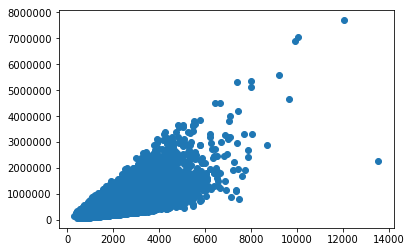

In [92]:
# Load & Quick look the data
house_price = pd.read_csv('kc_house_data.csv')
plt.scatter(house_price['sqft_living'], house_price['price'])
house_price.head()

In [93]:
# converting 'built' and 'renovated' data
house_price['age'] = 2018 - house_price['yr_built']
for index, row in house_price.iterrows():
    if house_price['yr_renovated'][index] == 0:
        house_price.loc[index, 'age_renovated'] = house_price.loc[index, 'age']
    else:
        house_price.loc[index, 'age_renovated'] = 2018 - house_price.loc[index, 'yr_renovated']

In [94]:
# Dropping the features we don't need
drop_fields = ['id', 'date', 'long', 'sqft_living15', 'sqft_lot15', 'zipcode', 'lat', 'long', 'grade', 'view', 'yr_built', 'yr_renovated']
house_price = house_price.drop(drop_fields, axis=1)

In [95]:
# Check features & data shape after processing.
print ('Shape of data: ' , house_price.shape)
print ('List of features: ', *house_price.columns.values, sep='\n')

Shape of data:  (21613, 12)
List of features: 
price
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
condition
sqft_above
sqft_basement
age
age_renovated


In [128]:
# correlation with price feature
print((house_price.corr()['price']).sort_values(ascending=False))

price            1.000000
sqft_living      0.702035
sqft_above       0.605567
bathrooms        0.525138
sqft_basement    0.323816
bedrooms         0.308350
waterfront       0.266369
floors           0.256794
sqft_lot         0.089661
condition        0.036362
age             -0.054012
age_renovated   -0.105755
Name: price, dtype: float64


In [153]:
# split the data set
[train, test] = train_test_split(house_price, test_size= 0.2)
[train, valid] = train_test_split(train, test_size= 0.2)
print('Train :', train.shape, '\nValid: ', valid.shape, '\nTest :', test.shape)

Train : (13832, 12) 
Valid:  (3458, 12) 
Test : (4323, 12)


In [154]:
# Splitting data
train_X = train.loc[:, train.columns != 'price']
train_y = train['price']
valid_X = valid.loc[:, valid.columns != 'price']
valid_y = valid['price']
test_X = test.loc[:, test.columns != 'price']
test_y = test['price']
print('X: ', train_X.shape, '\ny: ', train_y.shape)

X:  (13832, 11) 
y:  (13832,)


## Building Ridge Regression Model

In [161]:
class RidgeRegression(object):
    def __init__(self, learning_rate=1e-5, l2_penalty=1e-1, verbose=False, iteration=1e3):
        self.weights = None
        self.l2_penalty = l2_penalty
        self.learning_rate = learning_rate
        self.iteration = iteration
        self.cost_history = []
        
    def predict(self, X):
        y_pred= np.dot(X, self.weights)
        return(y_pred)

    def calculate_cost(self, y, y_pred):
        cost = np.sum((y - y_pred)**2) + self.l2_penalty*np.sum(self.weights ** 2)
        return cost

    def fit(self, X, y, learning_rate, l2_penalty, iteration, verbose):
        self.learning_rate = learning_rate
        self.l2_penalty = l2_penalty
        self.iteration = iteration
        # Case : 1 feature input data
        if len(X.shape) == 1: 
            self.weights = 0
        else: 
            self.weights = np.zeros(X.shape[1])
        for iter in range(int(iteration)):
            y_pred = self.predict(X)
            error = y - y_pred
            # store cost history for printing
            cost = self.calculate_cost(y, y_pred)
            self.cost_history.append(cost)
            # weight update
            self.weights += learning_rate*((np.dot(X.T, error) - l2_penalty*self.weights))
            # print progressing
            if verbose == True:
                sys.stdout.write("\rProgress: {:2.1f}".format(100 * iter/float(iteration)) \
                                    + "% ... Cost: " + str(cost))
                sys.stdout.flush()
            
    def l2_penalty_tuning(self, train_X, train_y, valid_X, valid_y, l2_penalty):
        # uses self.iteration, self.learning.
        lowest_cost = None
        best_l2_penalty = None
        print("Tuning Penalty...")
        for index, penalty in enumerate(l2_penalty_values):
            # train the model with training data
            self.fit(train_X, train_y, l2_penalty = penalty, learning_rate=self.learning_rate, iteration=self.iteration, verbose=False)
            # calculate the cost with valid data 
            y_pred = self.predict(valid_X)
            cost = np.sum((valid_y - y_pred)**2)
            if (best_l2_penalty == None or cost < lowest_cost):
                lowest_cost = cost
                best_l2_penalty = penalty
            print("[%d/%d] Penalty: %.5f    Cost: %.5e" %(index, len(l2_penalty), penalty, cost))
        print ("----------------")
        return [lowest_cost, best_l2_penalty]
    
    def r2_score(self, X, y):
        y_pred = self.predict(X)
        SSE = np.sum((y - y_pred) ** 2)
        SSTO = np.sum((y - y.mean()) ** 2)
        return (1 - (SSE / float(SSTO)))

In [162]:
ridge_model = RidgeRegression()
ridge_model.fit(train_X, train_y, learning_rate=3e-14, l2_penalty=10, iteration=1e3, verbose=True)

Progress: 99.9% ... Cost: 9.76122384115e+14

In [163]:
print (ridge_model.weights)

[  1.96330456e-01   1.38999246e-01   1.48281001e+02  -9.43053455e-02
   8.90600051e-02   3.51312203e-03   1.97854058e-01   1.18154919e+02
   3.01260826e+01   3.11042156e+00   2.81224194e+00]


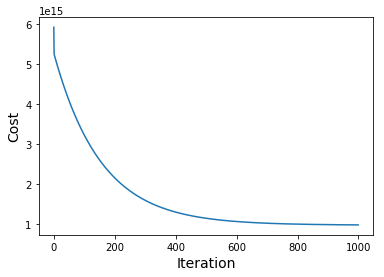

In [164]:
plt.plot(ridge_model.cost_history, label="Training cost")
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Cost', fontsize=14)

R2_score :  0.4813598252417063


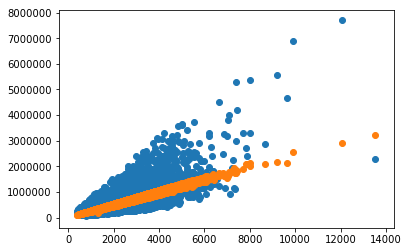

In [165]:
plt.scatter(train_X['sqft_living'], train_y)
plt.scatter(train_X['sqft_living'], ridge_model.predict(train_X))
print ("R2_score : ", model.r2_score(train_X, train_y))

In [166]:
l2_penalty_values = np.logspace(-4, 4, num=5)
[lowest_cost, best_penalty] = ridge_model.l2_penalty_tuning(train_X, train_y, valid_X, valid_y, l2_penalty = l2_penalty_values)

print("Best Penalty : %.5f   Cost : %.5e " %(best_penalty, lowest_cost))

Tuning Penalty...
[0/5] Penalty: 0.00010    Cost: 2.59980e+14
[1/5] Penalty: 0.01000    Cost: 2.59980e+14
[2/5] Penalty: 1.00000    Cost: 2.59980e+14
[3/5] Penalty: 100.00000    Cost: 2.59980e+14
[4/5] Penalty: 10000.00000    Cost: 2.59980e+14
----------------
Best Penalty : 0.00010   Cost : 2.59980e+14 


## Model with best L2 penalty

In [137]:
best_model = RidgeRegression()
best_model.fit(train_X, train_y, l2_penalty=best_penalty, learning_rate=3.5e-14, iteration=5e3, verbose=True)

Progress: 100.0% ... Cost: 9.29356215433e+14

0.47562133488271474

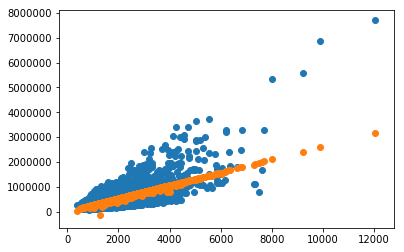

In [138]:
plt.scatter(test_X['sqft_living'], test_y)
plt.scatter(test_X['sqft_living'], best_model.predict(test_X))
model.r2_score(test_X, test_y)

# LASSO regression coordinate descent

## Normalize features
In the house dataset, features vary wildly in their relative magnitude: `sqft_living` is very large overall compared to `bedrooms`, for instance. As a result, weight for `sqft_living` would be much smaller than weight for `bedrooms`. This is problematic because "small" weights are dropped first as `l1_penalty` goes up. 

To give equal considerations for all features, we need to **normalize features**. we divide each feature by its 2-norm so that the transformed feature has norm 1.

In [170]:
# split the data set
[train, test] = train_test_split(house_price, test_size= 0.2)
[train, valid] = train_test_split(train, test_size= 0.2)
print('Train :', train.shape, '\nValid: ', valid.shape, '\nTest :', test.shape)

Train : (13832, 12) 
Valid:  (3458, 12) 
Test : (4323, 12)


In [171]:
# Splitting data
train_X = train.loc[:, train.columns != 'price']
train_y = train['price']
valid_X = valid.loc[:, valid.columns != 'price']
valid_y = valid['price']
test_X = test.loc[:, test.columns != 'price']
test_y = test['price']
print('X: ', train_X.shape, '\ny: ', train_y.shape)

X:  (13832, 11) 
y:  (13832,)


In [172]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix / norms
    return(normalized_features, norms)

In [173]:
# normalize data
[train_X, train_norms] = normalize_features(train_X)
print('Norms : ', *train_norms, sep='\n')
train_X.head()

Norms : 
410.795569596
265.084774176
268050.032751
4908561.04402
187.010694881
10.3923048454
407.87743257
232777.796375
61897.0640095
6521.78840503
6250.50325974


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,age,age_renovated
9202,0.012172,0.003772,0.012087,0.001085,0.010695,0.0,0.007355,0.013919,0.000000,0.001687,0.001760
13395,0.007303,0.003772,0.003805,0.002504,0.005347,0.0,0.009807,0.004382,0.000000,0.007820,0.008159
4909,0.007303,0.005659,0.006267,0.002801,0.005347,0.0,0.009807,0.007217,0.000000,0.010273,0.010719
7891,0.012172,0.010374,0.008954,0.003215,0.005347,0.0,0.009807,0.005155,0.019387,0.006747,0.007039
967,0.009737,0.010374,0.009513,0.001556,0.005347,0.0,0.007355,0.006186,0.017933,0.004907,0.005120


# Implementing Coordinate Descent with normalized features
We seek to obtain a sparse set of weights by minimizing the LASSO cost function
```
SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|).
```
(By convention, we do not include `w[0]` in the L1 penalty term. We never want to push the intercept to zero.)

The absolute value sign makes the cost function non-differentiable, so simple gradient descent is not viable (you would need to implement a method called subgradient descent). Instead, we will use **coordinate descent**: at each iteration, we will fix all weights but weight `i` and find the value of weight `i` that minimizes the objective. That is, we look for
```
argmin_{w[i]} [ SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|) ]
```
where all weights other than `w[i]` are held to be constant. We will optimize one `w[i]` at a time, circling through the weights multiple times.  
  1. Pick a coordinate `i`
  2. Compute `w[i]` that minimizes the cost function `SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|)`
  3. Repeat Steps 1 and 2 for all coordinates, multiple times
 

In [179]:
class LassoRegression():
    def __init__(self):
        self.weights = None
        self.l1_penalty = None
        self.iteration = None
        self.tolerance = None

    def predict(self, feature_matrix):
        predictions = np.dot(feature_matrix, self.weights)
        return(predictions)

    def lasso_coordinate_descent_step(self, i, X, y):
        # compute prediction
        prediction = self.predict(X)
        # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i]) ]
        ro_i = (X.iloc[:,i] * (y - prediction + self.weights[i]*X.iloc[:,i]) ).sum()
        if i == 0: # intercept -- do not regularize
            new_weight_i = ro_i 
        elif ro_i < -self.l1_penalty/2.:
            new_weight_i = ro_i + (self.l1_penalty/2)
        elif ro_i > self.l1_penalty/2.:
            new_weight_i = ro_i - (self.l1_penalty/2)
        else:
            new_weight_i = 0.

        return new_weight_i

    def fit(self, X, y, l1_penalty, tolerance=1e-1, verbose=False):
        self.l1_penalty = l1_penalty
        self.verbose = verbose
        self.tolerance = tolerance
        self.weights = np.zeros(X.shape[1])
        
        converge = True    
        print_index = 0
        iter = 0
        while(converge):
            max_change = 0
            iter += 1
            changes = []
            for i in range(len(self.weights)):
                old_weights_i = self.weights[i]
                self.weights[i] = self.lasso_coordinate_descent_step(i, X, y)
                #print "new weight = %d" %weights[i]
                this_change = self.weights[i] - old_weights_i
                changes.append(this_change)
                max_change =  max(np.absolute(changes))
                print_index += 1
                if(verbose == True and print_index % 500 == 0):    
                    print("max change : %.3f" %(max_change) )
                            
            if (max_change < self.tolerance or iter > 1e3) :
                converge = False
            
    def r2_score(self, X, y):
        y_pred = self.predict(X)
        SSE = np.sum((y - y_pred) ** 2)
        SSTO = np.sum((y - y.mean()) ** 2)
        return (1 - (SSE / float(SSTO)))
    
    def l1_penalty_tuning(self, train_X, train_y, valid_X, valid_y, l1_penalty, tolerance=10):
        lowest_cost = None
        best_l1_penalty = None
        print("Tuning Penalty...")
        for index, penalty in enumerate(l1_penalty_values):
            self.fit(train_X, train_y, l1_penalty = penalty, tolerance=tolerance, verbose=False)
            cost = sum((valid_y-self.predict(valid_X))**2)
            if (best_l1_penalty == None or cost < lowest_cost):
                lowest_cost = cost
                best_l1_penalty = penalty
            print("[%d/%d] Penalty: %.5f    Cost: %.5e" %(index, len(l1_penalty), penalty, cost))
        print ("----------------")
        return [lowest_cost, best_l1_penalty]

In [181]:
lasso_model = LassoRegression()
lasso_model.fit(train_X, train_y, l1_penalty=1, tolerance=10, verbose=True)

max change : 502650.747
max change : 187854.178
max change : 63732.160
max change : 21520.989
max change : 7043.920
max change : 2357.197
max change : 576.635
max change : 257.082
max change : 7.224
max change : 27.868


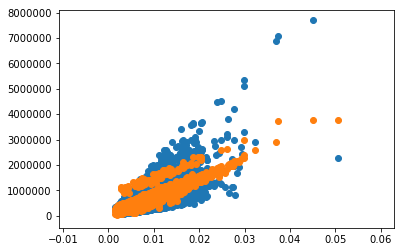

In [189]:
plt.scatter(train_X['sqft_living'], train_y)
plt.scatter(train_X['sqft_living'], lasso_model.predict(train_X))

In [183]:
# since we normalized train data, we have to normalize test data as well.
normalized_valid_X = valid_X / train_norms

In [184]:
# since train data is normalized, normalize the result weight to use it for test data set.
l1_penalty_values = np.logspace(1, 5, num=5)
[lowest_cost, best_penalty] = lasso_model.l1_penalty_tuning(train_X, train_y, normalized_valid_X, valid_y, l1_penalty = l1_penalty_values, tolerance=1e3)

print("Best Penalty : %.3f   Cost : %.5e " %(best_penalty, lowest_cost))

Tuning Penalty...
[0/5] Penalty: 10.00000    Cost: 2.02350e+14
[1/5] Penalty: 100.00000    Cost: 2.02350e+14
[2/5] Penalty: 1000.00000    Cost: 2.02347e+14
[3/5] Penalty: 10000.00000    Cost: 2.02332e+14
[4/5] Penalty: 100000.00000    Cost: 2.02206e+14
----------------
Best Penalty : 100000.000   Cost : 2.02206e+14 


In [186]:
best_lasso_model = LassoRegression()
best_lasso_model.fit(train_X, train_y, l1_penalty=best_penalty, tolerance=10, verbose=True)

max change : 521786.869
max change : 192029.341
max change : 53811.536
max change : 18840.320
max change : 11643.193
max change : 9937.226
max change : 3718.359
max change : 1354.504
max change : 223.197
max change : 379.711
max change : 143.864
max change : 30.024
max change : 32.148
max change : 12.069


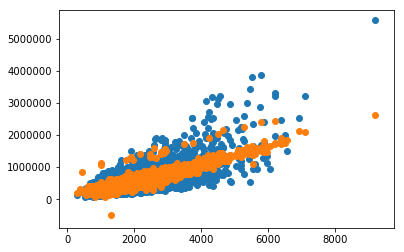

In [187]:
plt.scatter(test_X['sqft_living'], test_y)
plt.scatter(test_X['sqft_living'], best_lasso_model.predict(test_X/train_norms))